In [8]:
import requests
import xml.etree.ElementTree as ET
from typing import Dict, Any, List
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta
import re


def fetch_nucs(base_url: str, token: str, params: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Minimal NUCS API client that returns point-level records with timestamps.
    - base_url: real NUCS host (e.g., https://nucs.example.com) without angle brackets
    - token: securityToken value as provided (raw string, no < >)
    - params: query parameters per dataset (documentType, processType, etc.)
    Returns a list of dicts with at least: ts, procurement_price, quantity.
    """
    # Guard against placeholders to avoid DNS failures like '%3cnucs%3e'
    if not base_url or '<' in base_url or '>' in base_url:
        raise ValueError("base_url looks like a placeholder. Replace 'https://<NUCS>' with the real host, e.g., 'https://nucs.example.com'.")
    if not token or '<' in token or '>' in token:
        raise ValueError("securityToken looks like a placeholder. Use the raw token value without angle brackets.")

    url = base_url.rstrip('/') + '/api'
    q = {"securityToken": token}
    q.update(params or {})

    try:
        r = requests.get(url, params=q, timeout=60)
        print("NUCS request URL:", r.url)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        hint = (
            "Check DNS/VPN/proxy and that base_url resolves. "
            "Also ensure token and params match the dataset."
        )
        raise RuntimeError(f"NUCS request failed: {e}\n{hint}") from e

    # Parse XML. The API may emit one of these namespaces depending on the document.
    ns = {
        "bal": "urn:iec62325.351:tc57wg16:451-6:balancingdocument:4:0",
        "bal3": "urn:iec62325.351:tc57wg16:451-6:balancingdocument:3:0",
        "bal41": "urn:iec62325.351:tc57wg16:451-6:balancingdocument:4:1",
        "cap": "urn:iec62325.351:tc57wg16:451-3:capacitydocument:8:0",
    }

    root = ET.fromstring(r.content)

    # Helpers
    def ltag(e: ET.Element) -> str:
        return e.tag.split('}')[-1] if isinstance(e.tag, str) else ''

    _dur_re = re.compile(r"^P(T(?:(?P<h>\d+)H)?(?:(?P<m>\d+)M)?(?:(?P<s>\d+)S)?)$", re.I)

    def parse_iso_duration(text: str) -> timedelta:
        if not text:
            return timedelta(hours=1)
        m = _dur_re.match(text.strip())
        if not m:
            try:
                return timedelta(seconds=int(text))
            except Exception:
                return timedelta(hours=1)
        h = int(m.group('h') or 0)
        m_ = int(m.group('m') or 0)
        s = int(m.group('s') or 0)
        return timedelta(hours=h) + timedelta(minutes=m_) + timedelta(seconds=s)

    rows: List[Dict[str, Any]] = []

    # Collect TimeSeries regardless of namespace
    series_list = [el for el in root.iter() if ltag(el) == 'TimeSeries']

    for ts in series_list:
        # Find first Period under ts
        period = next((el for el in ts.iter() if ltag(el) == 'Period'), None)
        if period is None:
            continue

        # timeInterval
        ti = next((el for el in period.iter() if ltag(el) == 'timeInterval'), None)
        start_dt = end_dt = None
        if ti is not None:
            s_el = next((ch for ch in ti if ltag(ch) == 'start'), None)
            e_el = next((ch for ch in ti if ltag(ch) == 'end'), None)
            if s_el is not None and s_el.text:
                try:
                    start_dt = datetime.fromisoformat(s_el.text.replace('Z', '+00:00'))
                except Exception:
                    try:
                        start_dt = datetime.strptime(s_el.text, "%Y-%m-%dT%H:%MZ")
                    except Exception:
                        pass
            if e_el is not None and e_el.text:
                try:
                    end_dt = datetime.fromisoformat(e_el.text.replace('Z', '+00:00'))
                except Exception:
                    try:
                        end_dt = datetime.strptime(e_el.text, "%Y-%m-%dT%H:%MZ")
                    except Exception:
                        pass
            if start_dt is None and ti.text and '/' in ti.text:
                a, b = ti.text.split('/', 1)
                try:
                    start_dt = datetime.fromisoformat(a.replace('Z', '+00:00'))
                    end_dt = datetime.fromisoformat(b.replace('Z', '+00:00'))
                except Exception:
                    pass
        if start_dt is None:
            # Without a start, we cannot timestamp positions
            continue

        # resolution
        res_el = next((el for el in period.iter() if ltag(el) == 'resolution' and el.text), None)
        delta = parse_iso_duration(res_el.text if res_el is not None else 'PT60M')

        # metadata (optional)
        meta: Dict[str, Any] = {}
        for tag in ("businessType", "currency_Unit.name", "quantity_Measure_Unit.name", "price_Measure_Unit.name", "flowDirection.direction"):
            el = next((x for x in ts.iter() if ltag(x) == tag), None)
            if el is not None and el.text:
                meta[tag] = el.text

        # points
        for pt in [el for el in period.iter() if ltag(el) == 'Point']:
            # position
            pos_el = next((ch for ch in pt if ltag(ch) == 'position' and ch.text), None)
            if pos_el is None:
                continue
            try:
                position = int(pos_el.text)
            except Exception:
                continue

            # price
            price_val = None
            for el in pt.iter():
                if 'price' in ltag(el).lower() and el.text:
                    try:
                        price_val = float(el.text)
                        break
                    except Exception:
                        pass

            # quantity
            qty_val = None
            q_el = next((el for el in pt.iter() if ltag(el) == 'quantity' and el.text), None)
            if q_el is not None:
                try:
                    qty_val = float(q_el.text)
                except Exception:
                    pass

            ts_point = start_dt + (position - 1) * delta
            rec = {
                'ts': ts_point,
                'procurement_price': price_val,
                'quantity': qty_val,
                **meta,
            }
            rows.append(rec)

    return rows


# Demo usage (enabled). Fill real values, then set RUN_NUCS=True.
RUN_NUCS = True
base_url = "https://nucs.net"  # replace with the actual base URL, no angle brackets
api_key = os.getenv('NUCS_API_KEY')       # your real token string, no angle brackets

# Do NOT wrap the token in angle brackets; just pass the raw string
token = "deb6147d-c08c-4394-a3d1-43ed4c1885ff"

# Build 100-day periods from a start/end string in format YYYYMMDDHHMM
period_start = "202501010000"
period_end   = "202512162200"

fmt = "%Y%m%d%H%M"
start_dt = datetime.strptime(period_start, fmt)
end_dt   = datetime.strptime(period_end, fmt)

periods: List[Dict[str, str]] = []
cur = start_dt
while cur < end_dt:
    next_end = min(cur + timedelta(days=50), end_dt)
    periods.append({
        "periodStart": cur.strftime(fmt),
        "periodEnd": next_end.strftime(fmt),
    })
    cur = next_end

print(f"Generated {len(periods)} period chunk(s):", periods)

# Base params that are constant across requests
params_template: Dict[str, Any] = {
    "documentType": "A81",
    # A01=Day-ahead, A02=Intraday, A03=Balancing, A04=Capacity, A06=Forecast, A13=Long-term
    "processType": "A51",
    # Daily (A01/A02/A03/A04/A06/A13)
    "type_marketagreement.type": "A01",
    # EIC code
    "controlArea_domain": "10YNO-1--------2",
}

rows: List[List[Dict[str, Any]]] = []
for window in periods:
    params = {**params_template, **window}
    chunk_rows = fetch_nucs(base_url, token, params)
    print(f"  -> {len(chunk_rows)} points from {window['periodStart']} to {window['periodEnd']}")
    rows.append(chunk_rows)

print(f"Fetched {len(rows)} NUCS responses (list of lists).")

Generated 7 period chunk(s): [{'periodStart': '202501010000', 'periodEnd': '202502200000'}, {'periodStart': '202502200000', 'periodEnd': '202504110000'}, {'periodStart': '202504110000', 'periodEnd': '202505310000'}, {'periodStart': '202505310000', 'periodEnd': '202507200000'}, {'periodStart': '202507200000', 'periodEnd': '202509080000'}, {'periodStart': '202509080000', 'periodEnd': '202510280000'}, {'periodStart': '202510280000', 'periodEnd': '202512162200'}]


KeyboardInterrupt: 

Combined hourly rows: 7464
Saved CSV: ..\reports\dataframes\nucs_hourly_prices_full_year.csv


Saved: ..\reports\plots\nucs_hourly_prices_full_year.png
Saved: ..\reports\plots\nucs_hourly_price_hist_full_year.png
Saved: ..\reports\plots\nucs_hourly_price_hist_full_year.png
Saved: ..\reports\plots\nucs_hourly_price_by_hour_full_year.png
Saved: ..\reports\plots\nucs_hourly_price_by_hour_full_year.png


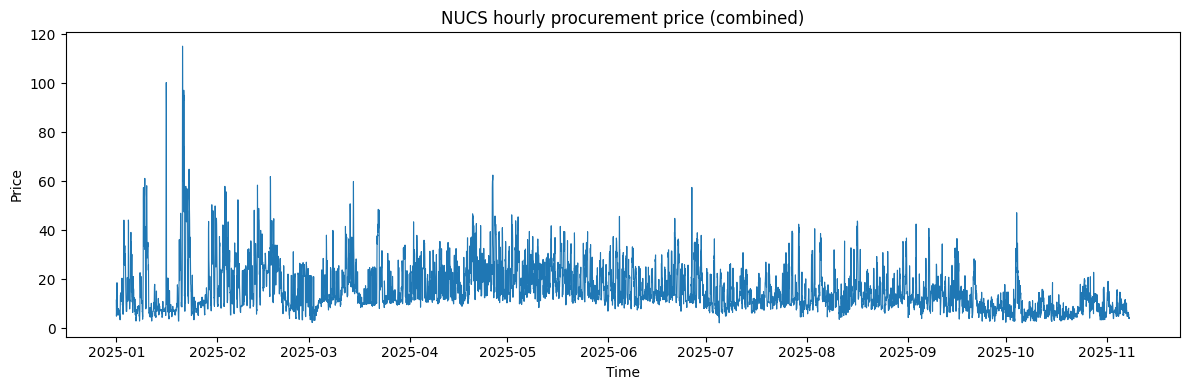

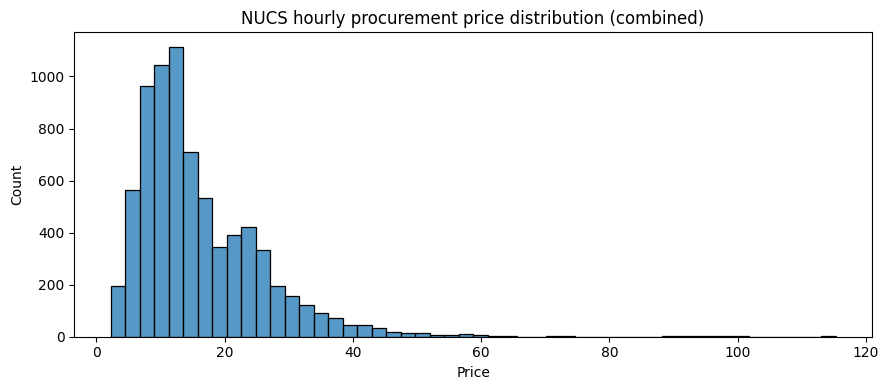

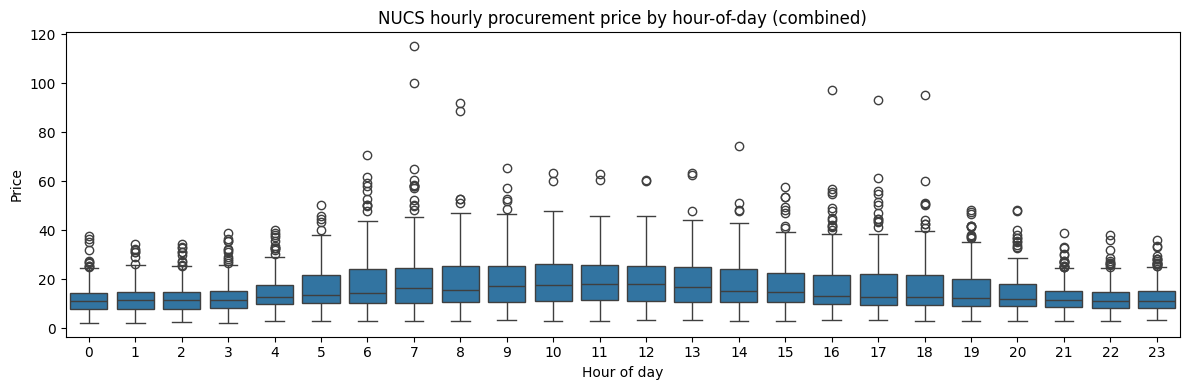

In [ ]:
# Combine all NUCS rows across periods into hourly DataFrame and save plots/CSV
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# rows is List[List[dict]]; flatten it
_flat = []
for part in (rows or []):
    if isinstance(part, list):
        _flat.extend([r for r in part if isinstance(r, dict)])
    elif isinstance(part, dict):
        _flat.append(part)

if not _flat:
    print("No parsed NUCS points in 'rows'. Ensure fetch_nucs returned records with 'ts'.")
else:
    dfp = pd.DataFrame(_flat)
    if 'ts' not in dfp.columns:
        raise RuntimeError("Expected 'ts' in NUCS point records. Please re-run Cell 1 to rebuild 'rows'.")

    # Build hourly series (mean of procurement_price per hour)
    hourly = (
        dfp.dropna(subset=['ts'])
           .set_index('ts')
           .sort_index()
           .resample('1h')
           .agg(procurement_price=('procurement_price', 'mean'),
                quantity=('quantity', 'sum'))
           .reset_index()
    )
    print('Combined hourly rows:', len(hourly))

    # Save CSV
    os.makedirs(os.path.join('..','reports','dataframes'), exist_ok=True)
    csv_path = os.path.join('..','reports','dataframes','nucs_hourly_prices_full_year.csv')
    hourly.to_csv(csv_path, index=False)
    print('Saved CSV:', csv_path)

    # Line plot
    os.makedirs(os.path.join('..','reports','plots'), exist_ok=True)
    plt.figure(figsize=(12,4))
    sns.lineplot(data=hourly, x='ts', y='procurement_price', linewidth=0.8)
    plt.title('NUCS hourly procurement price (combined)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.tight_layout()
    out_png = os.path.join('..','reports','plots','nucs_hourly_prices_full_year.png')
    plt.savefig(out_png, dpi=150)
    print('Saved:', out_png)

    # Histogram
    plt.figure(figsize=(9,4))
    sns.histplot(hourly['procurement_price'].dropna(), bins=50)
    plt.title('NUCS hourly procurement price distribution (combined)')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.tight_layout()
    hist_png = os.path.join('..','reports','plots','nucs_hourly_price_hist_full_year.png')
    plt.savefig(hist_png, dpi=150)
    print('Saved:', hist_png)

    # Boxplot by hour-of-day
    hourly['_hour'] = hourly['ts'].dt.hour
    plt.figure(figsize=(12,4))
    sns.boxplot(data=hourly, x='_hour', y='procurement_price')
    plt.title('NUCS hourly procurement price by hour-of-day (combined)')
    plt.xlabel('Hour of day')
    plt.ylabel('Price')
    plt.tight_layout()
    hod_png = os.path.join('..','reports','plots','nucs_hourly_price_by_hour_full_year.png')
    plt.savefig(hod_png, dpi=150)
    print('Saved:', hod_png)


In [ ]:
# Inspect the structure of `rows` to adapt parsing
from itertools import islice

def _preview_rows(rows_obj, n=1):
    print('rows type:', type(rows_obj), 'len:', (len(rows_obj) if hasattr(rows_obj, '__len__') else 'N/A'))
    if isinstance(rows_obj, list) and rows_obj:
        print('first element type:', type(rows_obj[0]))
        if isinstance(rows_obj[0], list):
            print('first inner len:', len(rows_obj[0]))
            if rows_obj[0]:
                print('first inner element type:', type(rows_obj[0][0]))
                if isinstance(rows_obj[0][0], dict):
                    print('first inner keys:', list(islice(rows_obj[0][0].keys(), 10)))
        elif isinstance(rows_obj[0], dict):
            print('first keys:', list(islice(rows_obj[0].keys(), 10)))
        else:
            print('first element repr:', repr(rows_obj[0])[:400])

_preview_rows(rows)

rows type: <class 'list'> len: 7
first element type: <class 'list'>
first inner len: 2400
first inner element type: <class 'dict'>
first inner keys: ['ts', 'procurement_price', 'quantity', 'businessType', 'currency_Unit.name', 'quantity_Measure_Unit.name', 'flowDirection.direction']


Parsed points: 14928 | breakdown: {'dict_ts': 14928}
Hourly rows: 7464
Last hour fetched: 2025-11-07 22:00
Last hour price: 4.35
Saved CSV: ..\reports\dataframes\nucs_hourly_prices_combined.csv


C:\Users\haako\AppData\Local\Temp\ipykernel_9056\193311146.py:154: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  last_hour_floor = pd.to_datetime(last_hour).floor('H')


Saved: ..\reports\plots\nucs_hourly_prices_combined.png
Saved: ..\reports\plots\nucs_hourly_price_hist_combined.png
Saved: ..\reports\plots\nucs_hourly_price_by_hour_combined.png
Saved: ..\reports\plots\nucs_hourly_price_by_hour_combined.png


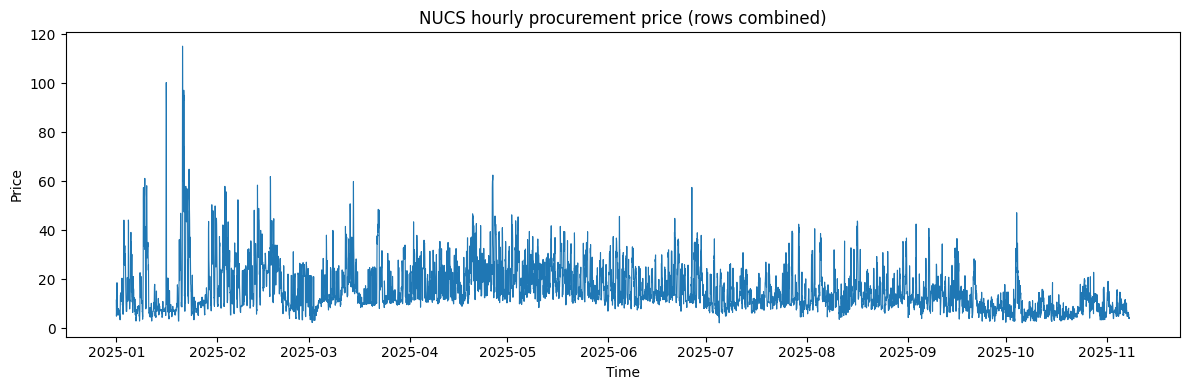

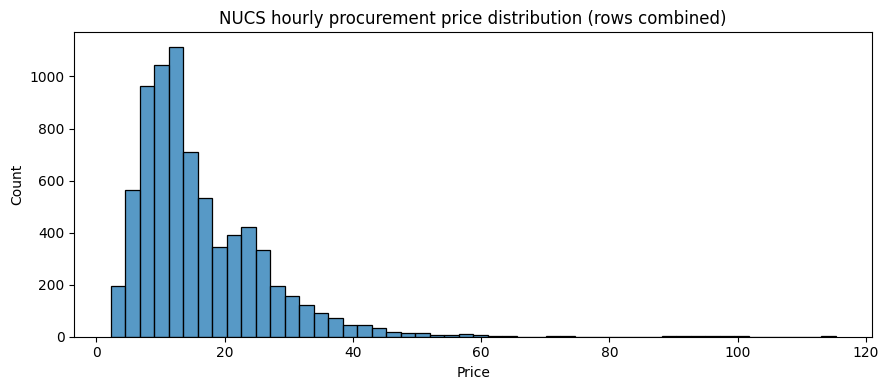

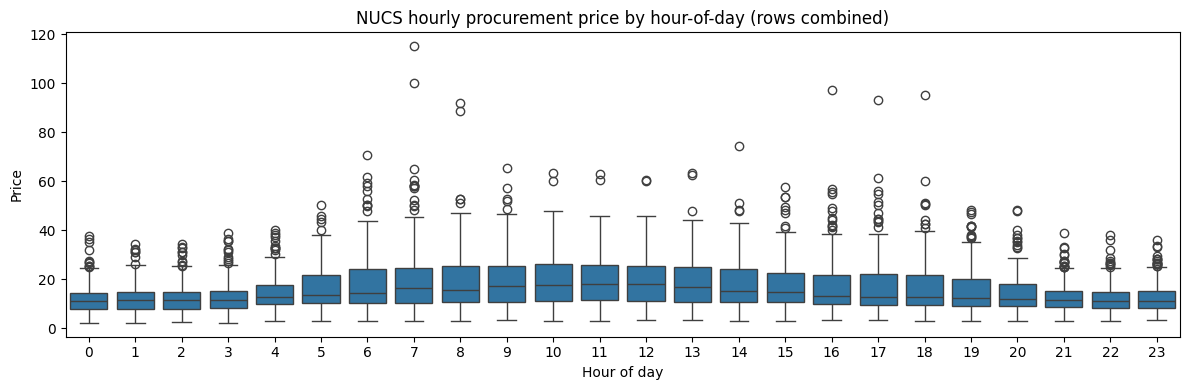

In [ ]:
# Parse whatever is in `rows` (responses/XML/elements/dicts) into hourly prices and save artifacts
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import re
from collections import defaultdict

_dur_re = re.compile(r"^P(T(?:(?P<h>\d+)H)?(?:(?P<m>\d+)M)?(?:(?P<s>\d+)S)?)$", re.I)

def _parse_iso_duration(text: str) -> timedelta:
    if not text:
        return timedelta(hours=1)
    m = _dur_re.match(str(text).strip())
    if not m:
        try:
            return timedelta(seconds=int(text))
        except Exception:
            return timedelta(hours=1)
    h = int(m.group('h') or 0)
    m_ = int(m.group('m') or 0)
    s = int(m.group('s') or 0)
    return timedelta(hours=h) + timedelta(minutes=m_) + timedelta(seconds=s)

ltag = lambda e: e.tag.split('}')[-1] if isinstance(e.tag, str) else ''

stats = defaultdict(int)

recs = []

def _parse_root(root):
    global recs
    series_list = [el for el in root.iter() if ltag(el) == 'TimeSeries']
    for ts in series_list:
        period = next((el for el in ts.iter() if ltag(el) == 'Period'), None)
        if period is None:
            stats['no_period'] += 1
            continue
        ti = next((el for el in period.iter() if ltag(el) == 'timeInterval'), None)
        start_dt = None
        if ti is not None:
            s_el = next((ch for ch in ti if ltag(ch) == 'start'), None)
            if s_el is not None and s_el.text:
                try:
                    start_dt = pd.to_datetime(s_el.text)
                except Exception:
                    pass
            if start_dt is None and ti.text and '/' in ti.text:
                a, _b = ti.text.split('/', 1)
                try:
                    start_dt = pd.to_datetime(a)
                except Exception:
                    pass
        res_el = next((el for el in period.iter() if ltag(el) == 'resolution' and el.text), None)
        delta = _parse_iso_duration(res_el.text if res_el is not None else 'PT60M')
        if start_dt is None:
            stats['no_start'] += 1
            continue
        for pt in [el for el in period.iter() if ltag(el) == 'Point']:
            pos_el = next((ch for ch in pt if ltag(ch) == 'position' and ch.text), None)
            if pos_el is None:
                stats['no_pos'] += 1
                continue
            try:
                position = int(pos_el.text)
            except Exception:
                stats['bad_pos'] += 1
                continue
            price_val = None
            for el in pt.iter():
                if 'price' in ltag(el).lower() and el.text:
                    try:
                        price_val = float(el.text)
                        break
                    except Exception:
                        pass
            qty_val = None
            q_el = next((el for el in pt.iter() if ltag(el) == 'quantity' and el.text), None)
            if q_el is not None:
                try:
                    qty_val = float(q_el.text)
                except Exception:
                    pass
            ts_point = pd.to_datetime(start_dt) + pd.to_timedelta(position - 1, unit='s') * 0 + (position - 1) * pd.to_timedelta(delta)
            recs.append({'ts': ts_point, 'procurement_price': price_val, 'quantity': qty_val})


def parse_rows(rows_obj):
    if rows_obj is None:
        return
    if isinstance(rows_obj, list):
        for item in rows_obj:
            parse_rows(item)
        return
    # requests.Response
    try:
        import requests
        if isinstance(rows_obj, requests.Response):
            try:
                root = ET.fromstring(rows_obj.content)
                _parse_root(root)
                stats['responses'] += 1
                return
            except Exception:
                pass
    except Exception:
        pass
    # bytes or str XML
    if isinstance(rows_obj, (bytes, str)):
        try:
            root = ET.fromstring(rows_obj)
            _parse_root(root)
            stats['xml_text'] += 1
            return
        except Exception:
            pass
    # xml element
    if isinstance(rows_obj, ET.Element):
        _parse_root(rows_obj)
        stats['xml_root'] += 1
        return
    # dict with ts
    if isinstance(rows_obj, dict):
        if 'ts' in rows_obj and ('procurement_price' in rows_obj or 'quantity' in rows_obj):
            recs.append({'ts': pd.to_datetime(rows_obj['ts']),
                         'procurement_price': rows_obj.get('procurement_price'),
                         'quantity': rows_obj.get('quantity')})
            stats['dict_ts'] += 1
            return
        stats['dict_skipped'] += 1
        return
    stats['unknown'] += 1

# Run parser
parse_rows(rows)
print('Parsed points:', len(recs), '| breakdown:', dict(stats))

if recs:
    dfp = pd.DataFrame(recs).dropna(subset=['ts'])
    hourly = (
        dfp.set_index('ts')
           .resample('1h')
           .agg(procurement_price=('procurement_price', 'mean'),
                quantity=('quantity', 'sum'))
           .reset_index()
    )
    print('Hourly rows:', len(hourly))
    # Print last fetched hour
    if not hourly.empty:
        last_hour = pd.to_datetime(hourly['ts']).max()
        try:
            last_hour_floor = pd.to_datetime(last_hour).floor('H')
        except Exception:
            last_hour_floor = last_hour
        print('Last hour fetched:', last_hour_floor.strftime('%Y-%m-%d %H:%M'))
        # price of last hours
        last_prices = hourly[hourly['ts'] == last_hour_floor]
        if not last_prices.empty:
            last_price = last_prices.iloc[0]['procurement_price']
            print('Last hour price:', last_price)
        else:
            print('No price found for last hour.')

    # Save
    os.makedirs(os.path.join('..','reports','dataframes'), exist_ok=True)
    csv_path = os.path.join('..','reports','dataframes','nucs_hourly_prices_combined.csv')
    hourly.to_csv(csv_path, index=False)
    print('Saved CSV:', csv_path)

    os.makedirs(os.path.join('..','reports','plots'), exist_ok=True)
    plt.figure(figsize=(12,4))
    sns.lineplot(data=hourly, x='ts', y='procurement_price', linewidth=0.8)
    plt.title('NUCS hourly procurement price (rows combined)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.tight_layout()
    out_png = os.path.join('..','reports','plots','nucs_hourly_prices_combined.png')
    plt.savefig(out_png, dpi=150)
    print('Saved:', out_png)

    plt.figure(figsize=(9,4))
    sns.histplot(hourly['procurement_price'].dropna(), bins=50)
    plt.title('NUCS hourly procurement price distribution (rows combined)')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.tight_layout()
    hist_png = os.path.join('..','reports','plots','nucs_hourly_price_hist_combined.png')
    plt.savefig(hist_png, dpi=150)
    print('Saved:', hist_png)

    hourly['_hour'] = hourly['ts'].dt.hour
    plt.figure(figsize=(12,4))
    sns.boxplot(data=hourly, x='_hour', y='procurement_price')
    plt.title('NUCS hourly procurement price by hour-of-day (rows combined)')
    plt.xlabel('Hour of day')
    plt.ylabel('Price')
    plt.tight_layout()
    hod_png = os.path.join('..','reports','plots','nucs_hourly_price_by_hour_combined.png')
    plt.savefig(hod_png, dpi=150)
    print('Saved:', hod_png)
else:
    print("No points parsed from 'rows'. If you already have 7 NUCS responses in memory, re-run this cell without re-running the fetch cell.")


In [9]:
# mFRR contracted reserves (DF09/A81, businessType=A97) via utils
from pathlib import Path
from datetime import datetime
import os, sys

# Paths
UPREG_ROOT = Path.cwd().parent  # notebooks -> upreg_classify
REPO_ROOT = UPREG_ROOT.parent   # repo root
sys.path.insert(0, str(UPREG_ROOT))  # allow `from src...`

# Load .env if available
try:
    from dotenv import load_dotenv, find_dotenv  # type: ignore
    dotenv_path = find_dotenv(usecwd=True)
    if not dotenv_path:
        dotenv_path = str(REPO_ROOT / '.env')
    loaded = load_dotenv(dotenv_path, override=True)
    print('dotenv path:', dotenv_path, '| loaded:', loaded, '| exists:', os.path.exists(dotenv_path))
except Exception as e:
    print('dotenv load error:', repr(e))

# Ensure latest nucs_api edits are picked up in this session
import importlib
import src.utils.nucs_api as nucs_api
importlib.reload(nucs_api)
from src.utils.nucs_api import get_mfrr_contracted_hourly

# Env vars with fallbacks
BASE_URL_KEYS = ['NUCS_BASE_URL','NUCS_BASEURL','NUCS_URL','NUCS_ENDPOINT']
API_KEY_KEYS = ['NUCS_API_KEY','NUCS_TOKEN','NUCS_ACCESS_TOKEN']

BASE_URL = next((os.getenv(k) for k in BASE_URL_KEYS if os.getenv(k)), '')
API_KEY = next((os.getenv(k) for k in API_KEY_KEYS if os.getenv(k)), '')

seen_nucs_keys = sorted([k for k in os.environ.keys() if k.upper().startswith('NUCS')])
print('Seen NUCS keys:', seen_nucs_keys)
print('Selected BASE_URL key:', next((k for k in BASE_URL_KEYS if os.getenv(k)), None))
print('Selected API_KEY key:', next((k for k in API_KEY_KEYS if os.getenv(k)), None))
print('Has BASE_URL:', bool(BASE_URL), '| Has API_KEY:', bool(API_KEY))

# Time range
PERIOD_START = '202401010000'
PERIOD_END = datetime.utcnow().strftime('%Y%m%d%H%M')

# Output
OUT_CSV = UPREG_ROOT / 'reports' / 'dataframes' / 'nucs_mfrr_contracted_hourly.csv'
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

if not BASE_URL or not API_KEY:
    raise RuntimeError('Missing NUCS_BASE_URL/NUCS_TOKEN/NUCS_API_KEY in environment (.env).')

pts, hourly = get_mfrr_contracted_hourly(
    base_url=BASE_URL,
    token=API_KEY,
    period_start=PERIOD_START,
    period_end=PERIOD_END,
    control_area='10YNO-1--------2',
    chunk_days=50,
    save_csv=str(OUT_CSV),
)
print('Points rows:', len(pts), '| Hourly rows:', len(hourly))
print('Saved:', OUT_CSV)
hourly.head(3)

dotenv path: c:\PythonProjects\rl_reserve_markets\upreg_classify\.env | loaded: True | exists: True
Seen NUCS keys: ['NUCS_API_KEY', 'NUCS_BASE_URL']
Selected BASE_URL key: NUCS_BASE_URL
Selected API_KEY key: NUCS_API_KEY
Has BASE_URL: True | Has API_KEY: True
{'periodStart': '202401010000', 'periodEnd': '202402200000'}


C:\Users\haako\AppData\Local\Temp\ipykernel_3184\4221172924.py:43: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  PERIOD_END = datetime.utcnow().strftime('%Y%m%d%H%M')


NUCS URL: https://www.nucs.net/api?securityToken=deb6147d-c08c-4394-a3d1-43ed4c1885ff&documentType=A81&type_marketagreement.type=A01&controlArea_domain=10YNO-1--------2&businessType=A96&periodStart=202401010000&periodEnd=202402200000
 -> 864 points from 202401010000 to 202402200000
{'periodStart': '202402200000', 'periodEnd': '202404100000'}
NUCS URL: https://www.nucs.net/api?securityToken=deb6147d-c08c-4394-a3d1-43ed4c1885ff&documentType=A81&type_marketagreement.type=A01&controlArea_domain=10YNO-1--------2&businessType=A96&periodStart=202402200000&periodEnd=202404100000
<?xml version="1.0" encoding="UTF-8"?>
<Acknowledgement_MarketDocument
	xmlns="urn:iec62325.351:tc57wg16:451-1:acknowledgementdocument:7:0">
	<mRID>75a7313f-ff31-4</mRID>
	<createdDateTime>2025-12-01T10:01:48Z</createdDateTime>

	<sender_MarketParticipant.mRID codingScheme="A01">10V1001C--000187</sender_MarketParticipant.mRID>
	<sender_MarketParticipant.marketRole.type>A32</sender_MarketParticipant.marketRole.type>

	<

,ts,procurement_price,quantity
0,2023-12-31 23:00:00+00:00,NaN,75.0
1,2024-01-01 00:00:00+00:00,NaN,0.0
2,2024-01-01 01:00:00+00:00,NaN,0.0
